<a href="https://colab.research.google.com/github/kimtony123/FemVerse/blob/main/deriv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import numpy as np # linear algebra
import pandas as pd
import yfinance as yf

df_close = yf.download("USDJPY=X", period="max",  interval = "1d")


df1 = df_close.reset_index()['Close']

# We will delete all future columns to start to predict next week forecast using last week forecasts. python starts at o so we take the first 10 weeks  to predict.
##df1 = df1.loc[:1025]
print(df1.tail(1))

a = df1.tail(1)
b =df1.tail(2)

[*********************100%%**********************]  1 of 1 completed

7094    147.201004
Name: Close, dtype: float64


TESTING THE MEAN REVERTING PROCESS OF OUR ASSET USING HURST EXPONENT

In [ ]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

def hurst(ts):
    """
    Returns the Hurst Exponent of the time series vector ts

    Parameters
    ----------
    ts : `numpy.array`
        Time series upon which the Hurst Exponent will be calculated

    Returns
    -------
    'float'
        The Hurst Exponent from the poly fit output
    """
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

# Assuming you have run the above code to obtain 'goog'!
print("Hurst(df1):  %s" % hurst(df1.values))







Hurst(df1):  0.5113379475794666


LETS TEST THE MEAN REVERTING OF OUR SERIES USING ADF

In [ ]:
import pandas as pd
import statsmodels.tsa.stattools as ts

def augmented_dickey_fuller(df1):
    """
    Carry out the Augmented Dickey-Fuller test for Google data.

    Parameters
    ----------
    goog : `pd.DataFrame`
      A DataFrame containing Google (GOOG) OHLCV data from
          01/09/2004-31/08/2020. Index is a Datetime object.

    Returns
    -------
    None
    """
    # Output the results of the Augmented Dickey-Fuller test for Google
    # with a lag order value of 1
    adf = ts.adfuller(df1, 1)
    print(adf)

df1_adf = augmented_dickey_fuller(df1)

print(df1_adf)

(-1.3215246889082894, 0.6192681186871101, 1, 7093, {'1%': -3.4312722709907555, '5%': -2.8619475705233897, '10%': -2.5669869457245524}, 17096.807480792784)
None


In [ ]:
if ((ai_pred_close > a.values[0]) and (ai_pred_close > b.values[0])):
    1
else:
    0

In [ ]:
price_data = yf.download("USDJPY=X", period="max",  interval = "1d")


import math

import numpy as np


def get_estimator(price_data, window=3, trading_periods=252, clean=True):

    log_ho = (price_data['High'] / price_data['Open']).apply(np.log)
    log_lo = (price_data['Low'] / price_data['Open']).apply(np.log)
    log_co = (price_data['Close'] / price_data['Open']).apply(np.log)

    log_oc = (price_data['Open'] / price_data['Close'].shift(1)).apply(np.log)
    log_oc_sq = log_oc**2

    log_cc = (price_data['Close'] / price_data['Close'].shift(1)).apply(np.log)
    log_cc_sq = log_cc**2

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    close_vol = log_cc_sq.rolling(
        window=window,
        center=False
    ).sum() * (1.0 / (window - 1.0))
    open_vol = log_oc_sq.rolling(
        window=window,
        center=False
    ).sum() * (1.0 / (window - 1.0))
    window_rs = rs.rolling(
        window=window,
        center=False
    ).sum() * (1.0 / (window - 1.0))

    k = 0.34 / (1.34 + (window + 1) / (window - 1))
    result = (open_vol + k * close_vol + (1 - k) * window_rs).apply(np.sqrt) * math.sqrt(trading_periods)

    if clean:
        return result.dropna()
    else:
        return result

price_data['vol'] = get_estimator(price_data)
price_data = price_data.dropna()
df = price_data

vol = df['vol'].iloc[-1]
price = df['Close'].iloc[-1]
print(vol)
print(price)

[*********************100%%**********************]  1 of 1 completed

0.19871774135256218
147.1649932861328


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

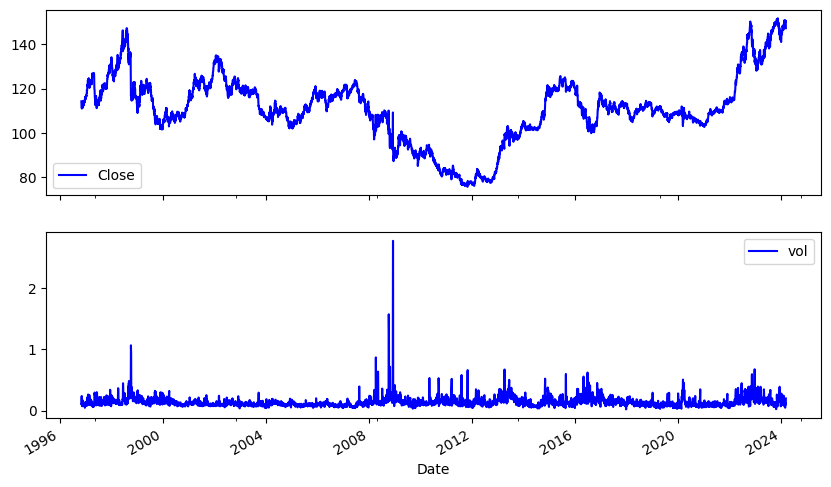

In [ ]:
df[['Close', 'vol']].plot(subplots=True, color='blue',figsize=(10, 6))


In [ ]:
import numpy as np
from scipy.sparse import diags, linalg
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded
from time import time
from scipy.stats import norm, lognorm

%matplotlib inline


#  Reset the random seed
np.random.seed(2)

#  Numer of simulations
N_sims = 100000

#  Stock information
S0 = price
r = 0.0525 / 252
dt = 0.0416667 * 2
sigma = vol/ np.sqrt(252)

#  Number of days per simulation
N_days = 1

#  Create an arraoy of random numbers, then delete the first element
epsilon = np.random.normal(  size = (N_sims * N_days + N_sims) )
epsilon = np.delete(epsilon, 0)

#  Create our Lambda
Lambda = r * dt + sigma * np.sqrt(dt) * epsilon
Lambda[N_days:N_days * N_sims + N_sims:N_days+1] = -1

ones = -np.ones((N_sims * N_days + N_sims))
ones[0:-1:N_days+1] = 1

M = diags( [Lambda + 1, ones], [-1, 0], format = 'csc')

Y = np.zeros( (N_sims * N_days + N_sims) )
Y[0:-1:N_days + 1] = S0

X = linalg.spsolve(M, Y)

X = np.reshape(X, (N_sims, N_days+1))


rows, cols = X.shape
if rows <= 11:
    for i in range(N_sims):
       plt.plot(X[i,:])

    print(X.shape)
    plt.grid(True)
    plt.xlabel('Day')
    plt.ylabel('Asset Price')


prices = X[:, -1]
print(prices)
ind = np.where( prices < price)
U = np.unique( ind[0] )

#  Work out and print the probability of a touch

prob = float(len(U)) / float(N_sims)
print( float(len(U)) / float(N_sims))

[147.13762539 148.03984848 146.71990482 ... 147.42647468 146.22637042
 146.34754374]
0.49863


[*********************100%%**********************]  1 of 1 completed


7094    148.117004
Name: High, dtype: float64
(7022, 1)
(7022,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 50)             10400     
                                                                 
 lstm_4 (LSTM)               (None, 1, 50)             20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
3/3 [==============================] - 0s 5ms/step
112.82506900178308
132.9421775107

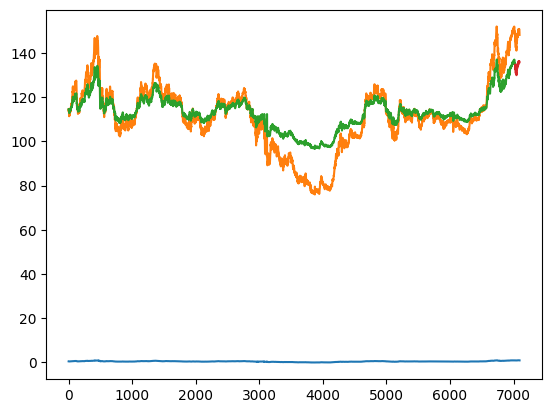

70
[0.77005166]
2
[[0.7700516581535339]]
[[134.46943116]]
134.46943115774502


In [ ]:
df_High = yf.download("USDJPY=X", period="max",  interval = "1d")


df1 =df_High.reset_index()['High']

# We will delete all future columns to start to predict next week forecast using last week forecasts. python starts at o so we take the first 10 weeks  to predict.
##df1 = df1.loc[:1025]
print(df1.tail(1))

a = df1.tail(1)
b =df1.tail(2)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
##splitting dataset into train and test split
training_size=int(len(df1)*0.99)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
training_size
test_size

import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

 # reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

print(X_train.shape), print(y_train.shape)


# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=1,batch_size=64,verbose=1)

import tensorflow as tf
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)


### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
train = math.sqrt(mean_squared_error(y_train,train_predict))
print(train)

### Test Data RMSE
test = math.sqrt(mean_squared_error(ytest,test_predict))
print(test)


import matplotlib.pyplot as plt
plt.plot(df1)

### Plotting
# shift train predictions for plotting
look_back=1
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

len(test_data)
new = len(test_data) -look_back
print (new)

x_input=test_data[new:].reshape(1,-1)
x_input.shape


temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=1
i=0
while(i< 1):

    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
print(lst_output)


ai_pred = scaler.inverse_transform(np.array(lst_output).reshape(-1,1))
print(ai_pred)

ai_pred_high = ai_pred[0][0]
print(ai_pred_high)



[*********************100%%**********************]  1 of 1 completed


7094    146.873993
Name: Low, dtype: float64
(7022, 1)
(7022,)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 50)             10400     
                                                                 
 lstm_7 (LSTM)               (None, 1, 50)             20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
3/3 [==============================] - 0s 7ms/step
111.42456125032226
130.97132752240

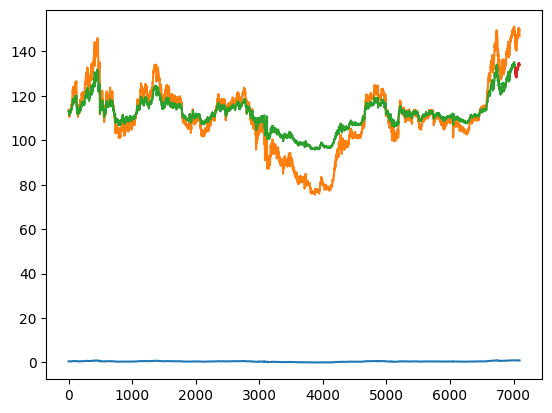

70
[0.7505447]
2
[[0.7505447268486023]]
[[132.36372353]]
132.36372352737135


In [ ]:
df_low = yf.download("USDJPY=X", period="max",  interval = "1d")


df1 =df_low.reset_index()['Low']

# We will delete all future columns to start to predict next week forecast using last week forecasts. python starts at o so we take the first 10 weeks  to predict.
##df1 = df1.loc[:1025]
print(df1.tail(1))

a = df1.tail(1)
b =df1.tail(2)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
##splitting dataset into train and test split
training_size=int(len(df1)*0.99)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
training_size
test_size

import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

 # reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

print(X_train.shape), print(y_train.shape)


# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=1,batch_size=64,verbose=1)

import tensorflow as tf
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)


### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
train = math.sqrt(mean_squared_error(y_train,train_predict))
print(train)

### Test Data RMSE
test = math.sqrt(mean_squared_error(ytest,test_predict))
print(test)


import matplotlib.pyplot as plt
plt.plot(df1)

### Plotting
# shift train predictions for plotting
look_back=1
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

len(test_data)
new = len(test_data) -look_back
print (new)

x_input=test_data[new:].reshape(1,-1)
x_input.shape


temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=1
i=0
while(i< 1):

    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
print(lst_output)


ai_pred = scaler.inverse_transform(np.array(lst_output).reshape(-1,1))
print(ai_pred)

ai_pred_low = ai_pred[0][0]
print(ai_pred_low)


In [ ]:
Starting_capital = 40
data =  [[Starting_capital]]

# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['Starting Capital'])

# print dataframe.
print(df)





   Starting Capital
0                40


In [ ]:

df['ai_pred_close'] = ai_pred_close

df['ai_pred_high'] = ai_pred_high

df['ai_pred_low'] = ai_pred_low
df['price'] = price

df['Buy/Sell'] =  1 if ((ai_pred_close > a.values[0]) and (ai_pred_close > b.values[0])) else 0
df

,Starting Capital,ai_pred_close,ai_pred_high,ai_pred_low,price,Buy/Sell
0,40,129.861825,134.469431,132.363724,147.164993,0


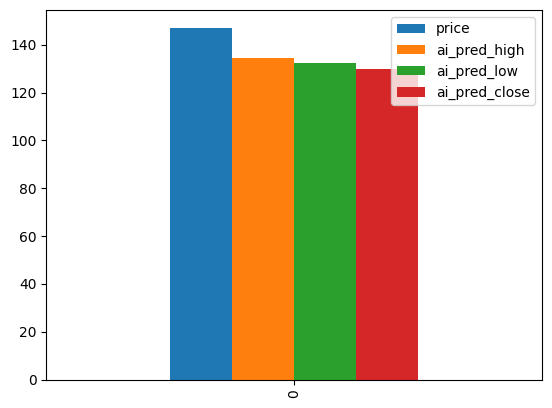

In [ ]:
ax = df[['price', 'ai_pred_high', 'ai_pred_low','ai_pred_close']].plot(kind="bar")

In [ ]:
df['5% trade allocation'] = df['Starting Capital'] * 0.05
df['10% trade allocation'] = df['Starting Capital'] * 0.1
df['15% trade allocation'] = df['Starting Capital'] * 0.15
#df['20% trade allocation'] = df['Starting Capital'] * 0.2
#df['25% trade allocation'] = df['Starting Capital'] * 0.25
#df['30% trade allocation'] = df['Starting Capital'] * 0.3
#df['35% trade allocation'] = df['Starting Capital'] * 0.35
#df['40% trade allocation'] = df['Starting Capital'] * 0.4
#df['45% trade allocation'] = df['Starting Capital'] * 0.45
#df['50% trade allocation'] = df['Starting Capital'] * 0.5
#df['55% trade allocation'] = df['Starting Capital'] * 0.55
#df['60% trade allocation'] = df['Starting Capital'] * 0.6
#df['65% trade allocation'] = df['Starting Capital'] * 0.65
#df['70% trade allocation'] = df['Starting Capital'] * 0.7
#df['75% trade allocation'] = df['Starting Capital'] * 0.75
#df['80% trade allocation'] = df['Starting Capital'] * 0.8
#df['85% trade allocation'] = df['Starting Capital'] * 0.85
#df['90% trade allocation'] = df['Starting Capital'] * 0.9
#df['95% trade allocation'] = df['Starting Capital'] * 0.95


deriv_reward = 1.8

reco = 0

df['5% Expected trade profit 55/45'] = (df['5% trade allocation']*0.55 * deriv_reward)- (df['5% trade allocation']) * 0.45 if( df['Buy/Sell'] == reco,True) else df['5% expected hedge profit 55/45']
df['5% expected hedge profit 55/45'] = (df['5% trade allocation'])* 0.45 * deriv_reward - (df['5% trade allocation']*0.55) if(df['Buy/Sell'] == reco,True) else df['5% expected trade profit 55/45']

df['5% Expected trade profit 60/40'] = (df['5% trade allocation']*0.6 * deriv_reward)- (df['5% trade allocation']) * 0.4 if( df['Buy/Sell'] == reco,True) else df['5% expected hedge profit 60/40']
df['5% expected hedge profit 60/40'] = (df['5% trade allocation'])* 0.4 * deriv_reward - (df['5% trade allocation']*0.6) if(df['Buy/Sell'] == reco,True) else df['5% expected trade profit 60/40']

df['5% Expected trade profit 65/35'] = (df['5% trade allocation']*0.65 * deriv_reward)- (df['5% trade allocation']) * 0.35 if( df['Buy/Sell'] == reco,True) else df['5% expected hedge profit 65/35']
df['5% expected hedge profit 65/35'] = (df['5% trade allocation'])* 0.35 * deriv_reward - (df['5% trade allocation']*0.65) if(df['Buy/Sell'] == reco,False) else df['5% Expected trade profit 65/35']


df['5% Expected trade profit 70/30'] = (df['5% trade allocation']*0.70 * deriv_reward)- (df['5% trade allocation']) * 0.3 if( df['Buy/Sell'] == reco,True) else df['5% expected hedge profit 70/30']
df['5% expected hedge profit 70/30'] = (df['5% trade allocation'])* 0.30 * deriv_reward - (df['5% trade allocation']*0.7) if(df['Buy/Sell'] == reco,False) else df['5% Expected trade profit 70/30']

df['5% Expected trade profit 75/25'] = (df['5% trade allocation']*0.75 * deriv_reward)- (df['5% trade allocation']) * 0.25 if( df['Buy/Sell'] == reco,True) else df['5% expected hedge profit 75/25']
df['5% expected hedge profit 75/25'] = (df['5% trade allocation'])* 0.250 * deriv_reward - (df['5% trade allocation']*0.75) if(df['Buy/Sell'] == reco,False) else df['5% Expected trade profit 75/25']

df['5% Expected trade profit 80/20'] = (df['5% trade allocation']*0.80 * deriv_reward)- (df['5% trade allocation']) * 0.2 if( df['Buy/Sell'] == reco,True) else df['5% expected hedge profit 80/20']
df['5% expected hedge profit 80/20'] = (df['5% trade allocation'])* 0.2 * deriv_reward - (df['5% trade allocation']*0.8) if(df['Buy/Sell'] == reco,False) else df['5% Expected trade profit 80/20']

df['5% Expected trade profit 85/15'] = (df['5% trade allocation']*0.85 * deriv_reward)- (df['5% trade allocation']) * 0.15 if( df['Buy/Sell'] == reco,True) else df['5% expected hedge profit 85/15']
df['5% expected hedge profit 85/15'] = (df['5% trade allocation'])* 0.15 * deriv_reward - (df['5% trade allocation']*0.85) if(df['Buy/Sell'] == reco,False) else df['5% Expected trade profit 85/15']


df['5% Expected trade profit 90/10'] = (df['5% trade allocation']*0.9 * deriv_reward)- (df['5% trade allocation']) * 0.1 if( df['Buy/Sell'] == reco,True) else df['5% expected hedge profit 90/10']
df['5% expected hedge profit 90/10'] = (df['5% trade allocation'])* 0.10 * deriv_reward - (df['5% trade allocation']*0.9) if(df['Buy/Sell'] == reco,False) else df['5% Expected trade profit 90/10']

df['5% Expected trade profit 95/5'] = (df['5% trade allocation']*0.95 * deriv_reward)- (df['5% trade allocation']) * 0.05 if( df['Buy/Sell'] == reco,True) else df['5% expected hedge profit 95/5']
df['5% expected hedge profit 95/5'] = (df['5% trade allocation'])* 0.05 * deriv_reward - (df['5% trade allocation']*0.95) if(df['Buy/Sell'] == reco,False) else df['5% Expected trade profit 95/5']









df['10% Expected trade profit 55/45'] = (df['10% trade allocation']*0.55 * deriv_reward)- (df['10% trade allocation']) * 0.45 if( df['Buy/Sell'] == reco,True) else df['10% expected hedge profit 55/45']
df['10% expected hedge profit 55/45'] = (df['10% trade allocation'])* 0.45 * deriv_reward - (df['10% trade allocation']*0.55) if(df['Buy/Sell'] == reco,True) else df['10% expected trade profit 55/45']

df['10% Expected trade profit 60/40'] = (df['10% trade allocation']*0.6 * deriv_reward)- (df['10% trade allocation']) * 0.4 if( df['Buy/Sell'] == reco,True) else df['10% expected hedge profit 60/40']
df['10% expected hedge profit 60/40'] = (df['10% trade allocation'])* 0.4 * deriv_reward - (df['10% trade allocation']*0.6) if(df['Buy/Sell'] == reco,True) else df['10% expected trade profit 60/40']

df['10% Expected trade profit 65/35'] = (df['10% trade allocation']*0.65 * deriv_reward)- (df['10% trade allocation']) * 0.35 if( df['Buy/Sell'] == reco,True) else df['10% expected hedge profit 65/35']
df['10% expected hedge profit 65/35'] = (df['10% trade allocation'])* 0.35 * deriv_reward - (df['10% trade allocation']*0.65) if(df['Buy/Sell'] == reco,False) else df['10% Expected trade profit 65/35']


df['10% Expected trade profit 70/30'] = (df['10% trade allocation']*0.70 * deriv_reward)- (df['10% trade allocation']) * 0.3 if( df['Buy/Sell'] == reco,True) else df['10% expected hedge profit 70/30']
df['10% expected hedge profit 70/30'] = (df['10% trade allocation'])* 0.30 * deriv_reward - (df['10% trade allocation']*0.7) if(df['Buy/Sell'] == reco,False) else df['10% Expected trade profit 70/30']

df['10% Expected trade profit 75/25'] = (df['10% trade allocation']*0.75 * deriv_reward)- (df['10% trade allocation']) * 0.25 if( df['Buy/Sell'] == reco,True) else df['10% expected hedge profit 75/25']
df['10% expected hedge profit 75/25'] = (df['10% trade allocation'])* 0.250 * deriv_reward - (df['10% trade allocation']*0.75) if(df['Buy/Sell'] == reco,False) else df['10% Expected trade profit 75/25']

df['10% Expected trade profit 80/20'] = (df['10% trade allocation']*0.80 * deriv_reward)- (df['10% trade allocation']) * 0.2 if( df['Buy/Sell'] == reco,True) else df['10% expected hedge profit 80/20']
df['10% expected hedge profit 80/20'] = (df['10% trade allocation'])* 0.2 * deriv_reward - (df['10% trade allocation']*0.8) if(df['Buy/Sell'] == reco,False) else df['10% Expected trade profit 80/20']

df['10% Expected trade profit 85/15'] = (df['10% trade allocation']*0.85 * deriv_reward)- (df['10% trade allocation']) * 0.15 if( df['Buy/Sell'] == reco,True) else df['10% expected hedge profit 85/15']
df['10% expected hedge profit 85/15'] = (df['10% trade allocation'])* 0.15 * deriv_reward - (df['10% trade allocation']*0.85) if(df['Buy/Sell'] == reco,False) else df['10% Expected trade profit 85/15']


df['10% Expected trade profit 90/10'] = (df['10% trade allocation']*0.9 * deriv_reward)- (df['10% trade allocation']) * 0.1 if( df['Buy/Sell'] == reco,True) else df['10% expected hedge profit 90/10']
df['10% expected hedge profit 90/10'] = (df['10% trade allocation'])* 0.10 * deriv_reward - (df['10% trade allocation']*0.9) if(df['Buy/Sell'] == reco,False) else df['10% Expected trade profit 90/10']

df['10% Expected trade profit 95/5'] = (df['10% trade allocation']*0.95 * deriv_reward)- (df['10% trade allocation']) * 0.05 if( df['Buy/Sell'] == reco,True) else df['10% expected hedge profit 95/5']
df['10% expected hedge profit 95/5'] = (df['10% trade allocation'])* 0.05 * deriv_reward - (df['10% trade allocation']*0.95) if(df['Buy/Sell'] == reco,False) else df['10% Expected trade profit 95/5']





df['15% Expected trade profit 55/45'] = (df['15% trade allocation']*0.55 * deriv_reward)- (df['15% trade allocation']) * 0.45 if( df['Buy/Sell'] == reco,True) else df['15% expected hedge profit 55/45']
df['15% expected hedge profit 55/45'] = (df['15% trade allocation'])* 0.45 * deriv_reward - (df['15% trade allocation']*0.55) if(df['Buy/Sell'] == reco,True) else df['15% expected trade profit 55/45']

df['15% Expected trade profit 60/40'] = (df['15% trade allocation']*0.6 * deriv_reward)- (df['15% trade allocation']) * 0.4 if( df['Buy/Sell'] == reco,True) else df['15% expected hedge profit 60/40']
df['15% expected hedge profit 60/40'] = (df['15% trade allocation'])* 0.4 * deriv_reward - (df['15% trade allocation']*0.6) if(df['Buy/Sell'] == reco,True) else df['15% expected trade profit 60/40']

df['15% Expected trade profit 65/35'] = (df['15% trade allocation']*0.65 * deriv_reward)- (df['15% trade allocation']) * 0.35 if( df['Buy/Sell'] == reco,True) else df['15% expected hedge profit 65/35']
df['15% expected hedge profit 65/35'] = (df['15% trade allocation'])* 0.35 * deriv_reward - (df['15% trade allocation']*0.65) if(df['Buy/Sell'] == reco,False) else df['15% Expected trade profit 65/35']


df['15% Expected trade profit 70/30'] = (df['15% trade allocation']*0.70 * deriv_reward)- (df['15% trade allocation']) * 0.3 if( df['Buy/Sell'] == reco,True) else df['15% expected hedge profit 70/30']
df['15% expected hedge profit 70/30'] = (df['15% trade allocation'])* 0.30 * deriv_reward - (df['15% trade allocation']*0.7) if(df['Buy/Sell'] == reco,False) else df['15% Expected trade profit 70/30']

df['15% Expected trade profit 75/25'] = (df['15% trade allocation']*0.75 * deriv_reward)- (df['15% trade allocation']) * 0.25 if( df['Buy/Sell'] == reco,True) else df['15% expected hedge profit 75/25']
df['15% expected hedge profit 75/25'] = (df['15% trade allocation'])* 0.250 * deriv_reward - (df['15% trade allocation']*0.75) if(df['Buy/Sell'] == reco,False) else df['15% Expected trade profit 75/25']

df['15% Expected trade profit 80/20'] = (df['15% trade allocation']*0.80 * deriv_reward)- (df['15% trade allocation']) * 0.2 if( df['Buy/Sell'] == reco,True) else df['15% expected hedge profit 80/20']
df['15% expected hedge profit 80/20'] = (df['15% trade allocation'])* 0.2 * deriv_reward - (df['15% trade allocation']*0.8) if(df['Buy/Sell'] == reco,False) else df['15% Expected trade profit 80/20']

df['15% Expected trade profit 85/15'] = (df['15% trade allocation']*0.85 * deriv_reward)- (df['15% trade allocation']) * 0.15 if( df['Buy/Sell'] == reco,True) else df['15% expected hedge profit 85/15']
df['15% expected hedge profit 85/15'] = (df['15% trade allocation'])* 0.15 * deriv_reward - (df['15% trade allocation']*0.85) if(df['Buy/Sell'] == reco,False) else df['15% Expected trade profit 85/15']


df['15% Expected trade profit 90/10'] = (df['15% trade allocation']*0.9 * deriv_reward)- (df['15% trade allocation']) * 0.1 if( df['Buy/Sell'] == reco,True) else df['15% expected hedge profit 90/10']
df['15% expected hedge profit 90/10'] = (df['15% trade allocation'])* 0.10 * deriv_reward - (df['15% trade allocation']*0.9) if(df['Buy/Sell'] == reco,False) else df['15% Expected trade profit 90/10']

df['15% Expected trade profit 95/5'] = (df['15% trade allocation']*0.95 * deriv_reward)- (df['15% trade allocation']) * 0.05 if( df['Buy/Sell'] == reco,True) else df['15% expected hedge profit 95/5']
df['15% expected hedge profit 95/5'] = (df['15% trade allocation'])* 0.05 * deriv_reward - (df['15% trade allocation']*0.95) if(df['Buy/Sell'] == reco,False) else df['15% Expected trade profit 95/5']










df

,Starting Capital,ai_pred_close,ai_pred_high,ai_pred_low,price,Buy/Sell,5% trade allocation,10% trade allocation,15% trade allocation,5% Expected trade profit 55/45,...,15% Expected trade profit 75/25,15% expected hedge profit 75/25,15% Expected trade profit 80/20,15% expected hedge profit 80/20,15% Expected trade profit 85/15,15% expected hedge profit 85/15,15% Expected trade profit 90/10,15% expected hedge profit 90/10,15% Expected trade profit 95/5,15% expected hedge profit 95/5
0,40,129.861825,134.469431,132.363724,147.164993,0,2.0,4.0,6.0,1.08,...,6.6,-1.8,7.44,-2.64,8.28,-3.48,9.12,-4.32,9.96,-5.16


In [ ]:
trades = 100


df['5% expected real GR 55/45'] = ( (((Starting_capital + df['5% Expected trade profit 55/45'])**prob) * (Starting_capital + (df['5% expected hedge profit 55/45'])**1-prob) )** 1/trades )-1

df['5% expected real GR 60/40'] = (( ((Starting_capital + df['5% Expected trade profit 60/40'])**prob) * (Starting_capital + (df['5% expected hedge profit 60/40'])**1-prob) )** 1/trades) -1

df['5% expected real GR 65/35'] = (( ((Starting_capital + df['5% Expected trade profit 65/35'])**prob) * (Starting_capital + (df['5% expected hedge profit 65/35'])**1-prob) )** 1/trades) -1

df['5% expected real GR 70/30'] = (( ((Starting_capital + df['5% Expected trade profit 70/30'])**prob) * (Starting_capital + (df['5% expected hedge profit 70/30'])**1-prob) )** 1/trades) -1

df['5% expected real GR 75/25'] = (( ((Starting_capital + df['5% Expected trade profit 75/25'])**prob) * (Starting_capital + (df['5% expected hedge profit 75/25'])**1-prob) )** 1/trades) -1

df['5% expected real GR 80/20'] = (( ((Starting_capital + df['5% Expected trade profit 80/20'])**prob) * (Starting_capital + (df['5% expected hedge profit 80/20'])**1-prob) )** 1/trades) -1

df['5% expected real GR 85/15'] = (( ((Starting_capital + df['5% Expected trade profit 85/15'])**prob) * (Starting_capital + (df['5% expected hedge profit 85/15'])**1-prob) )** 1/trades) -1

df['5% expected real GR 90/10'] = (( ((Starting_capital + df['5% Expected trade profit 90/10'])**prob) * (Starting_capital + (df['5% expected hedge profit 90/10'])**1-prob) )** 1/trades) -1

df['5% expected real GR 95/5'] = (( ((Starting_capital + df['5% Expected trade profit 95/5'])**prob) * (Starting_capital + (df['5% expected hedge profit 95/5'])**1-prob) )** 1/trades) -1




df['10% expected real GR 55/45'] = ( (((Starting_capital + df['10% Expected trade profit 55/45'])**prob) * (Starting_capital + (df['10% expected hedge profit 55/45'])**1-prob) )** 1/trades )-1

df['10% expected real GR 60/40'] = (( ((Starting_capital + df['10% Expected trade profit 60/40'])**prob) * (Starting_capital + (df['10% expected hedge profit 60/40'])**1-prob) )** 1/trades) -1

df['10% expected real GR 65/35'] = (( ((Starting_capital + df['10% Expected trade profit 65/35'])**prob) * (Starting_capital + (df['10% expected hedge profit 65/35'])**1-prob) )** 1/trades) -1

df['10% expected real GR 70/30'] = (( ((Starting_capital + df['10% Expected trade profit 70/30'])**prob) * (Starting_capital + (df['10% expected hedge profit 70/30'])**1-prob) )** 1/trades) -1

df['10% expected real GR 75/25'] = (( ((Starting_capital + df['10% Expected trade profit 75/25'])**prob) * (Starting_capital + (df['10% expected hedge profit 75/25'])**1-prob) )** 1/trades) -1

df['10% expected real GR 80/20'] = (( ((Starting_capital + df['10% Expected trade profit 80/20'])**prob) * (Starting_capital + (df['10% expected hedge profit 80/20'])**1-prob) )** 1/trades) -1

df['10% expected real GR 85/15'] = (( ((Starting_capital + df['10% Expected trade profit 85/15'])**prob) * (Starting_capital + (df['10% expected hedge profit 85/15'])**1-prob) )** 1/trades) -1

df['10% expected real GR 90/10'] = (( ((Starting_capital + df['10% Expected trade profit 90/10'])**prob) * (Starting_capital + (df['10% expected hedge profit 90/10'])**1-prob) )** 1/trades) -1

df['10% expected real GR 95/5'] = (( ((Starting_capital + df['10% Expected trade profit 95/5'])**prob) * (Starting_capital + (df['10% expected hedge profit 95/5'])**1-prob) )** 1/trades) -1




df['15% expected real GR 55/45'] = ( (((Starting_capital + df['15% Expected trade profit 55/45'])**prob) * (Starting_capital + (df['15% expected hedge profit 55/45'])**1-prob) )** 1/trades )-1

df['15% expected real GR 60/40'] = (( ((Starting_capital + df['15% Expected trade profit 60/40'])**prob) * (Starting_capital + (df['15% expected hedge profit 60/40'])**1-prob) )** 1/trades) -1

df['15% expected real GR 65/35'] = (( ((Starting_capital + df['15% Expected trade profit 65/35'])**prob) * (Starting_capital + (df['15% expected hedge profit 65/35'])**1-prob) )** 1/trades) -1

df['15% expected real GR 70/30'] = (( ((Starting_capital + df['15% Expected trade profit 70/30'])**prob) * (Starting_capital + (df['15% expected hedge profit 70/30'])**1-prob) )** 1/trades) -1

df['15% expected real GR 75/25'] = (( ((Starting_capital + df['15% Expected trade profit 75/25'])**prob) * (Starting_capital + (df['15% expected hedge profit 75/25'])**1-prob) )** 1/trades) -1

df['15% expected real GR 80/20'] = (( ((Starting_capital + df['15% Expected trade profit 80/20'])**prob) * (Starting_capital + (df['15% expected hedge profit 80/20'])**1-prob) )** 1/trades) -1

df['15% expected real GR 85/15'] = (( ((Starting_capital + df['15% Expected trade profit 85/15'])**prob) * (Starting_capital + (df['15% expected hedge profit 85/15'])**1-prob) )** 1/trades) -1

df['15% expected real GR 90/10'] = (( ((Starting_capital + df['15% Expected trade profit 90/10'])**prob) * (Starting_capital + (df['15% expected hedge profit 90/10'])**1-prob) )** 1/trades) -1

df['15% expected real GR 95/5'] = (( ((Starting_capital + df['15% Expected trade profit 95/5'])**prob) * (Starting_capital + (df['15% expected hedge profit 95/5'])**1-prob) )** 1/trades) -1




df

,Starting Capital,ai_pred_close,ai_pred_high,ai_pred_low,price,Buy/Sell,5% trade allocation,10% trade allocation,15% trade allocation,5% Expected trade profit 55/45,...,10% expected real GR 95/5,15% expected real GR 55/45,15% expected real GR 60/40,15% expected real GR 65/35,15% expected real GR 70/30,15% expected real GR 75/25,15% expected real GR 80/20,15% expected real GR 85/15,15% expected real GR 90/10,15% expected real GR 95/5
0,40,129.861825,134.469431,132.363724,147.164993,0,2.0,4.0,6.0,1.08,...,1.449826,1.68618,1.656593,1.625711,1.593554,1.560144,1.525501,1.489643,1.45259,1.414358


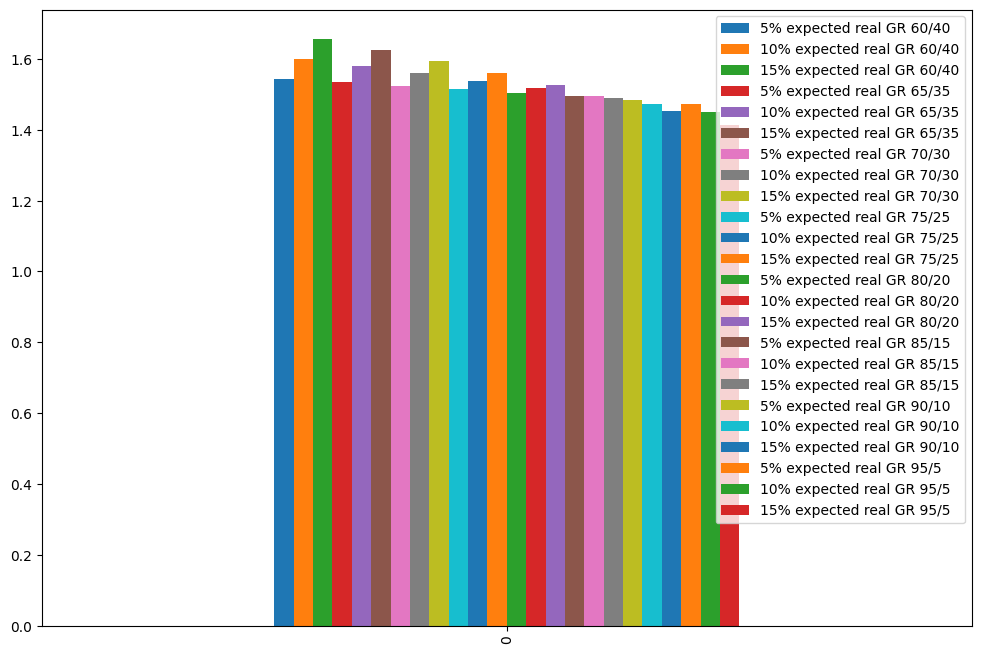

In [ ]:
ax = df[['5% expected real GR 60/40','10% expected real GR 60/40', '15% expected real GR 60/40','5% expected real GR 65/35','10% expected real GR 65/35', '15% expected real GR 65/35','5% expected real GR 70/30','10% expected real GR 70/30', '15% expected real GR 70/30','5% expected real GR 75/25','10% expected real GR 75/25', '15% expected real GR 75/25','5% expected real GR 80/20','10% expected real GR 80/20', '15% expected real GR 80/20','5% expected real GR 85/15','10% expected real GR 85/15', '15% expected real GR 85/15','5% expected real GR 90/10','10% expected real GR 90/10', '15% expected real GR 90/10','5% expected real GR 95/5','10% expected real GR 95/5', '15% expected real GR 95/5']].plot(kind="bar",figsize=(12, 8))